# Recurrent neural network (RNN) for sentiment analysis

### Problems of using CNN for NLP tasks?

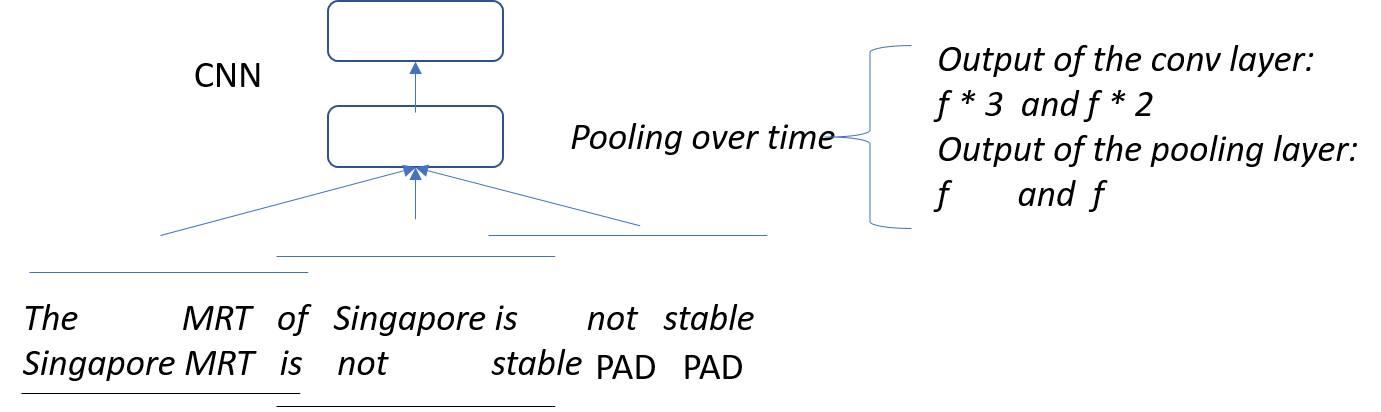


### RNN is good at processing sequences of variable length

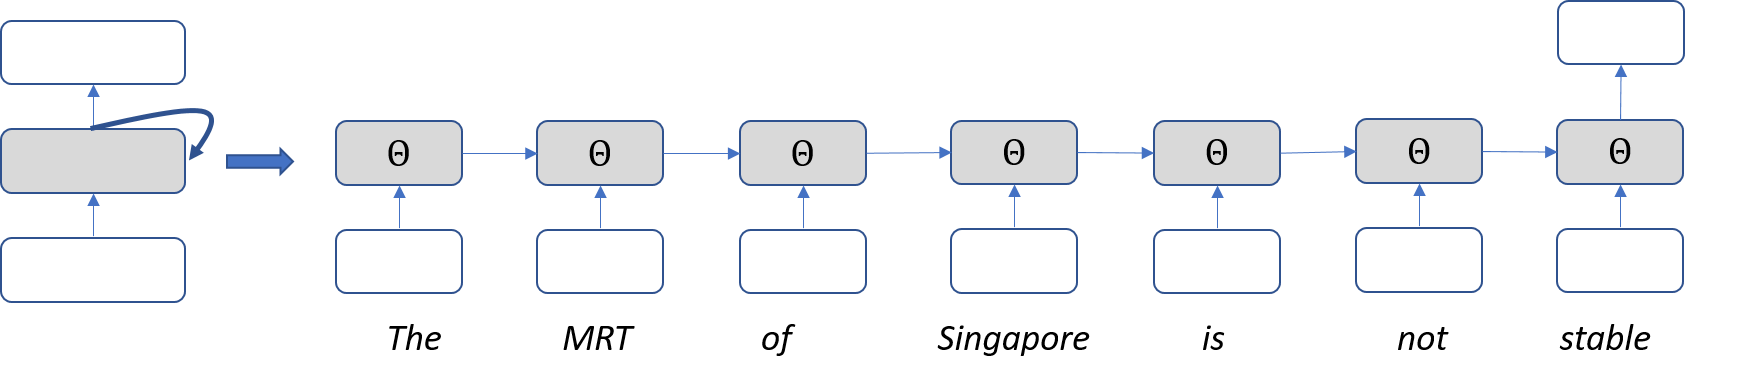


### Architecture of RNN for sentiment analysis

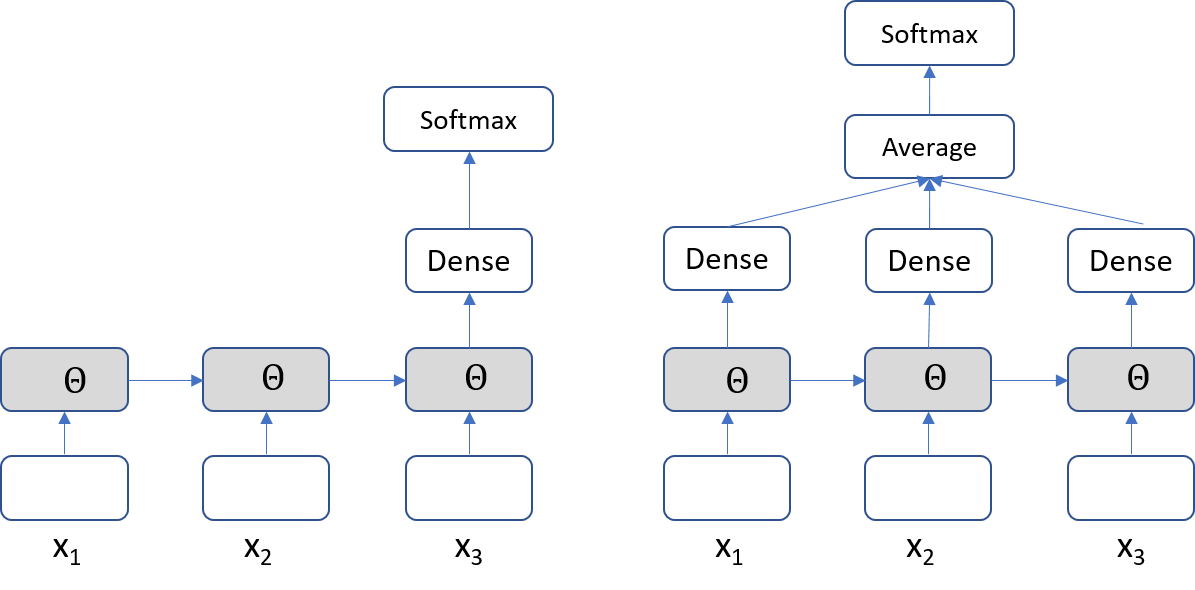

### Prepare text data

The imdb dataset is used here again for sentiment analysis.

In [1]:
from __future__ import print_function
from keras.preprocessing import sequence
from keras.datasets import imdb


max_features = 20000
maxlen = 80  # cut texts after this number of words (among top max_features most common words)
batch_size = 32
hidden_size = 128
embedding_size = 128

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print("x_train shape: ", x_train.shape)

Using TensorFlow backend.


25000 train sequences
25000 test sequences
x_train shape:  (25000, 80)


### Build model 

* Each word is represented by a vector of length max_features by the embedding layer, and then fed into the RNN unit.
* The hidden feature of the RNN unit is then fed into a linear feature transformation layer (Dense), which generates a single value reprenting the score for being postive.
* The final activation layer normalize the score to be within (0, 1).

In [2]:
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import SimpleRNN

model = Sequential()
model.add(Embedding(max_features, embedding_size, mask_zero=True, input_length=maxlen))
model.add(SimpleRNN(hidden_size, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 80, 128)           2560000   
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 128)               32896     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 2,593,025
Trainable params: 2,593,025
Non-trainable params: 0
_________________________________________________________________


### Training 

* loss function: binary_crossentropy is $-tlogp - (1-t)log(1-p)$, where t=1 if the true label is positive; otherwise 0.
* optimizer (SGD): Adam
* metric: Accuracy = num of correct prediction / num of total samples

In [3]:
# try using different optimizers and different optimizer configs
optimizer = RMSprop(lr=0.01, clipnorm=5.)
model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

print('Train...')
model.fit(x_train, y_train, batch_size=batch_size, epochs=10, validation_data=(x_test, y_test))
model.save_weights('ckpt/simplernn.h5')

Train...
Train on 25000 samples, validate on 25000 samples
Epoch 1/10
25000/25000 [==============================] - 119s - loss: 0.6876 - acc: 0.5426 - val_loss: 0.6581 - val_acc: 0.5795TA
Epoch 2/10
25000/25000 [==============================] - 115s - loss: 0.5919 - acc: 0.6766 - val_loss: 0.6083 - val_acc: 0.6645 2s - l
Epoch 3/10
25000/25000 [==============================] - 115s - loss: 0.4988 - acc: 0.7535 - val_loss: 0.5400 - val_acc: 0.7371
Epoch 4/10
25000/25000 [==============================] - 115s - loss: 0.4737 - acc: 0.7724 - val_loss: 0.6208 - val_acc: 0.7045
Epoch 5/10
25000/25000 [==============================] - 115s - loss: 0.4020 - acc: 0.8194 - val_loss: 0.7192 - val_acc: 0.6640
Epoch 6/10
25000/25000 [==============================] - 115s - loss: 0.3643 - acc: 0.8414 - val_loss: 0.6371 - val_acc: 0.6694
Epoch 7/10
25000/25000 [==============================] - 114s - loss: 0.4161 - acc: 0.8052 - val_loss: 0.7008 - val_acc: 0.6497
Epoch 8/10
25000/25000 [=====

### Prediction

how his evolved as both man and ape was outstanding not to mention the scenery of the film christopher lambert was astonishing as lord of christopher is the soul to this masterpiece i became so with his performance i could feel my heart pounding the of the movie still moves me to this day his portrayal of john was oscar worthy as he should have been nominated for it [ 0.37998417]
as he spouts the one liners out i also like the scenes with at the beginning find her very sexy when she's wearing all that fetish gear i can't be the only one surely i personally think bride of chucky is a fantastic film total entertainment from start to finish great humour horror in equal measure at only 85 minutes long it never becomes boring or dull a personal favourite of mine watch it as soon as you can [ 0.78183335]
strong enough to cope if you want to see good acting and the reality of life do not miss this movie favorite scenes the restaurant coming to kate and all the making of a table out of broken 

## RNN Unit

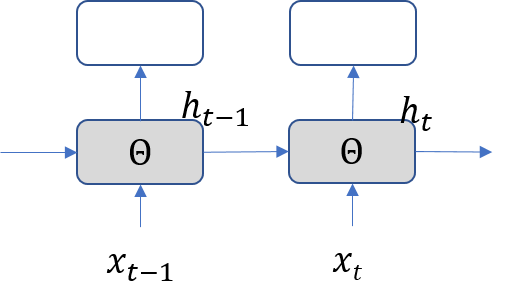

$$h_t = f(h_{t-1}, x_t|\Theta)$$

* Vanilla RNN
* LSTM
* GRU

## Vanilla RNN

$$h_t = a(h_{t-1}U+x_tW)$$
$$x_t \in R^{d_x}, h_t\in R^{d_h}, U\in R^{d_h \times d_h}, W\in R^{d_x \times d_h}$$
a() = tanh, ReLu, Sigmoid

In [3]:
import keras
class VanillaRNNCell(keras.layers.Layer):

    def __init__(self, units, **kwargs):
        self.units = units
        self.state_size = units
        super(VanillaRNNCell, self).__init__(**kwargs)

    def build(self, input_shape):
        """Create weight matrix"""
        self.W = self.add_weight(shape=(input_shape[-1], self.units), initializer='uniform', name='kernel')
        self.U = self.add_weight(shape=(self.units, self.units), initializer='uniform', name='recurrent_kernel')
        self.built = True

    def call(self, inputs, states):
        """Called per position/timestep for a batch of data"""
        prev_output = states[0]
        h = K.dot(inputs, self.W)
        output = h + K.dot(prev_output, self.U)
        # can also add dropout here
        return output, [output]

In [4]:
from keras.layers import RNN, Embedding, Dense
from keras import Sequential
from keras import backend as K

model = Sequential()
model.add(Embedding(max_features, embedding_size,  mask_zero=True, input_length=maxlen))
model.add(RNN(VanillaRNNCell(hidden_size)))
model.add(Dense(1, activation='sigmoid'))

# try using different optimizers and different optimizer configs
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print('Train...')
model.fit(x_train, y_train, batch_size=batch_size, epochs=10, validation_data=(x_test, y_test))
model.save_weights('ckpt/vanilla.h5')

Train...
Train on 25000 samples, validate on 25000 samples
Epoch 1/10
25000/25000 [==============================] - 118s 5ms/step - loss: 0.5578 - acc: 0.7023 - val_loss: 0.4414 - val_acc: 0.793416 - acc: 0. - ETA: 1s - loss: 0.5604 - 
Epoch 2/10
25000/25000 [==============================] - 112s 4ms/step - loss: 0.3524 - acc: 0.8480 - val_loss: 0.4130 - val_acc: 0.8098
Epoch 3/10
25000/25000 [==============================] - 111s 4ms/step - loss: 0.2150 - acc: 0.9178 - val_loss: 0.4800 - val_acc: 0.8216
Epoch 4/10
25000/25000 [==============================] - 111s 4ms/step - loss: 0.1229 - acc: 0.9555 - val_loss: 0.5977 - val_acc: 0.7938
Epoch 5/10
25000/25000 [==============================] - 112s 4ms/step - loss: 0.1051 - acc: 0.9609 - val_loss: 0.7090 - val_acc: 0.7905
Epoch 6/10
25000/25000 [==============================] - 112s 4ms/step - loss: 0.0656 - acc: 0.9754 - val_loss: 0.7576 - val_acc: 0.7539
Epoch 7/10
25000/25000 [==============================] - 112s 4ms/step -

## LSTM

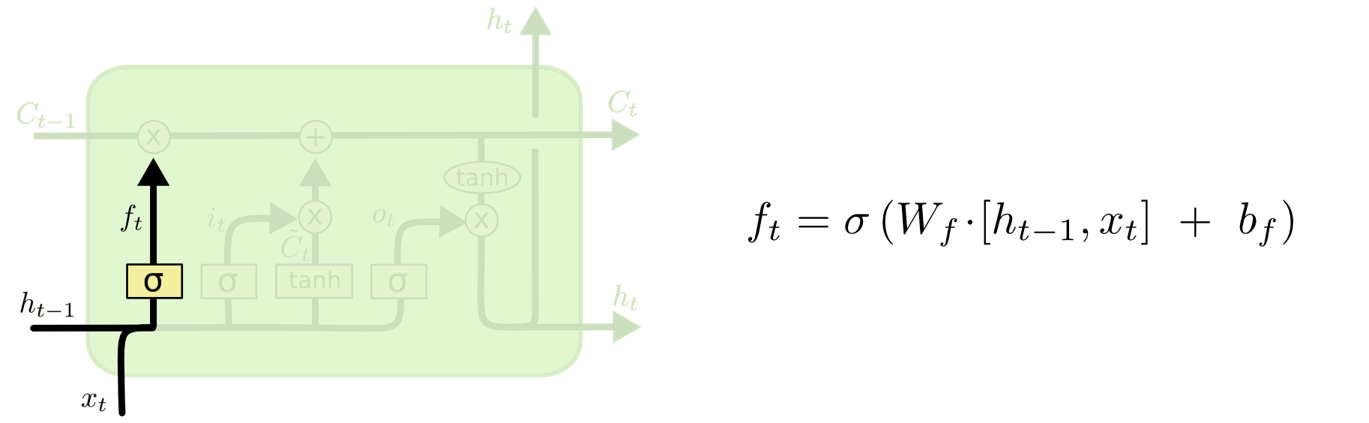
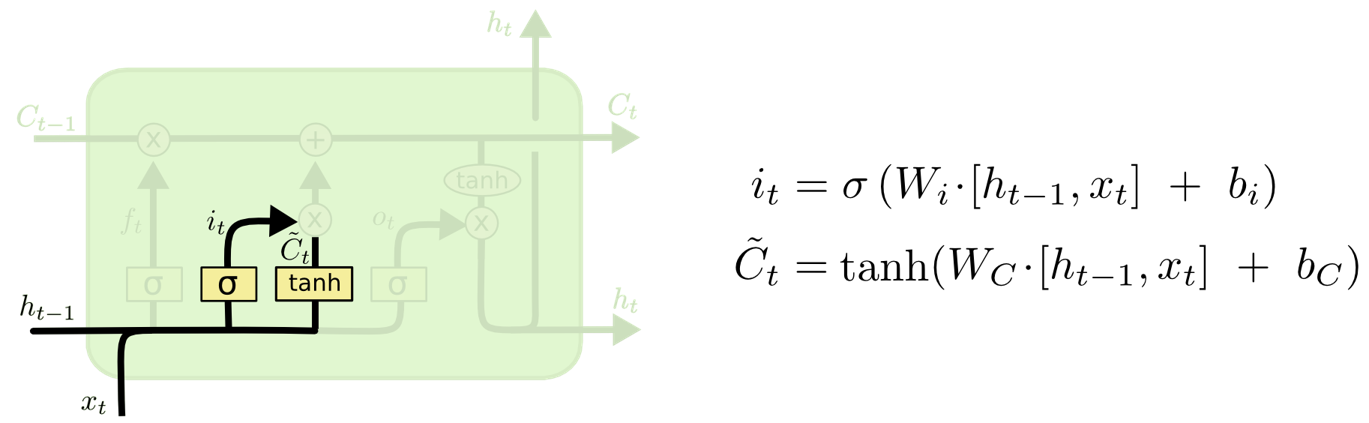
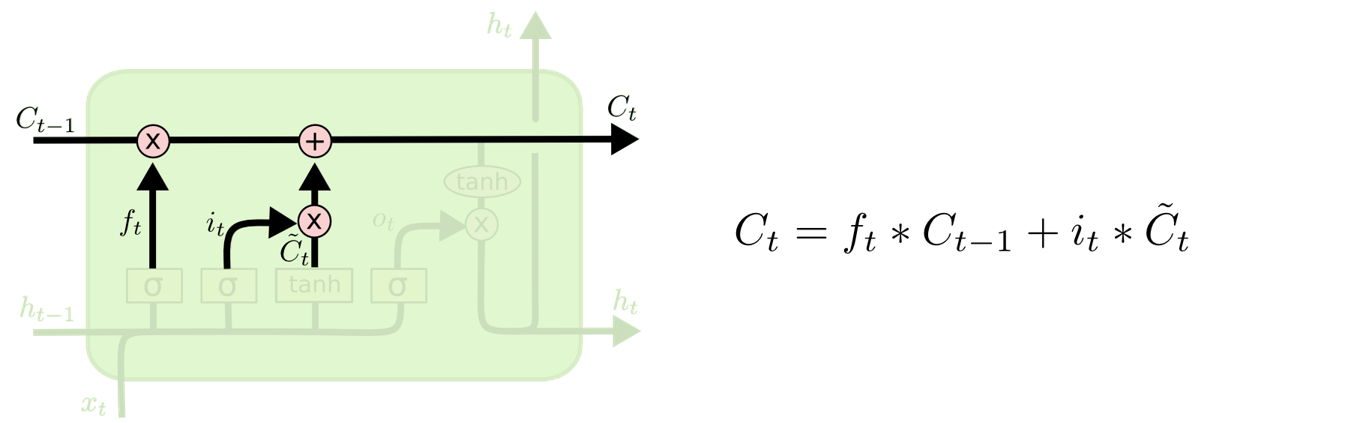
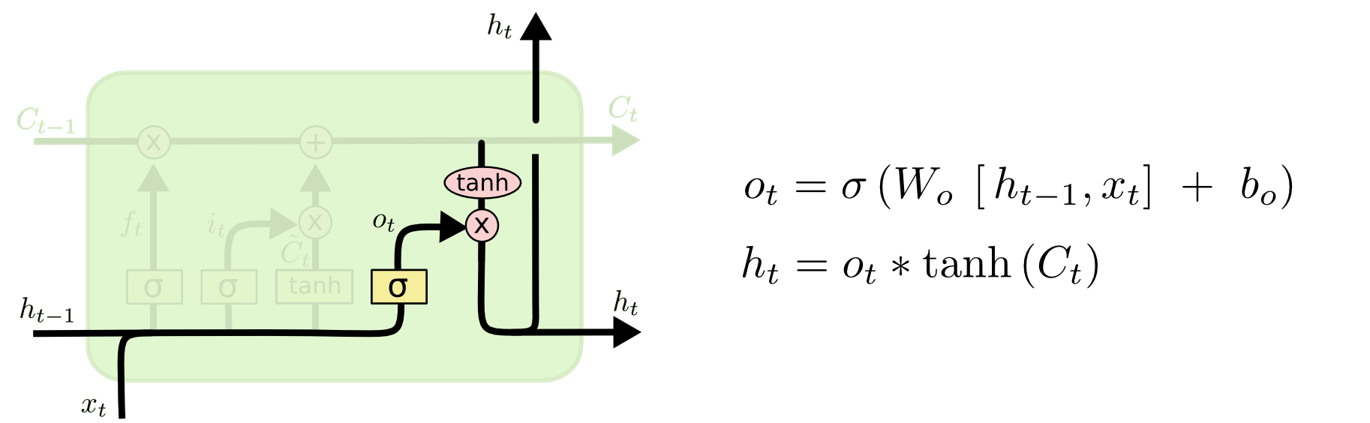

**Gate + States**
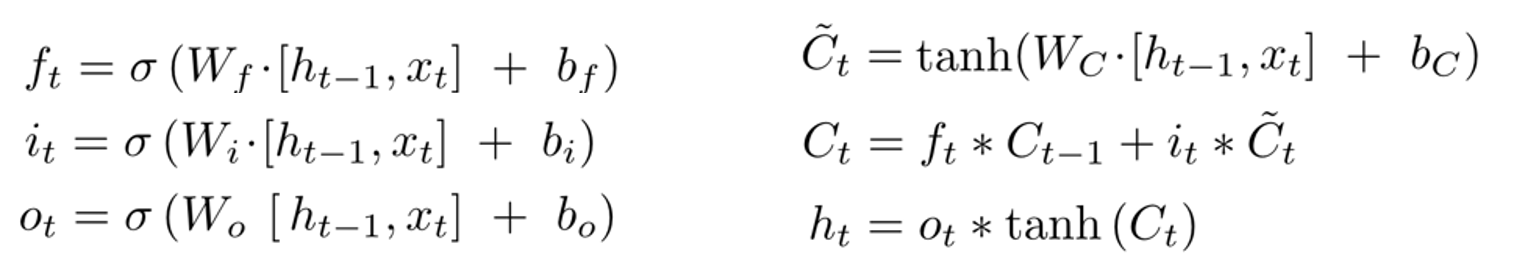

In [7]:
from keras.layers import LSTM, Embedding, Dense
from keras.models import Sequential
print('Build model...')
model = Sequential()
model.add(Embedding(max_features, embedding_size, mask_zero=True, input_length=maxlen))
model.add(LSTM(hidden_size, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

# try using different optimizers and different optimizer configs
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print('Train...')
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=10,
          validation_data=(x_test, y_test))
model.save_weights('ckpt/lstm.h5')
          

Build model...
Train...
Train on 25000 samples, validate on 25000 samples
Epoch 1/10
25000/25000 [==============================] - 349s 14ms/step - loss: 0.4621 - acc: 0.7838 - val_loss: 0.4432 - val_acc: 0.7942
Epoch 2/10
25000/25000 [==============================] - 342s 14ms/step - loss: 0.2977 - acc: 0.8782 - val_loss: 0.3757 - val_acc: 0.8359
Epoch 3/10
25000/25000 [==============================] - 343s 14ms/step - loss: 0.2174 - acc: 0.9159 - val_loss: 0.4441 - val_acc: 0.8303
Epoch 4/10
20736/25000 [=======================>......] - ETA: 40s - loss: 0.1470 - acc: 0.9463

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



25000/25000 [==============================] - 340s 14ms/step - loss: 0.0332 - acc: 0.9890 - val_loss: 0.7682 - val_acc: 0.8194
Epoch 10/10
25000/25000 [==============================] - 342s 14ms/step - loss: 0.0284 - acc: 0.9906 - val_loss: 0.8560 - val_acc: 0.8175


## GRU

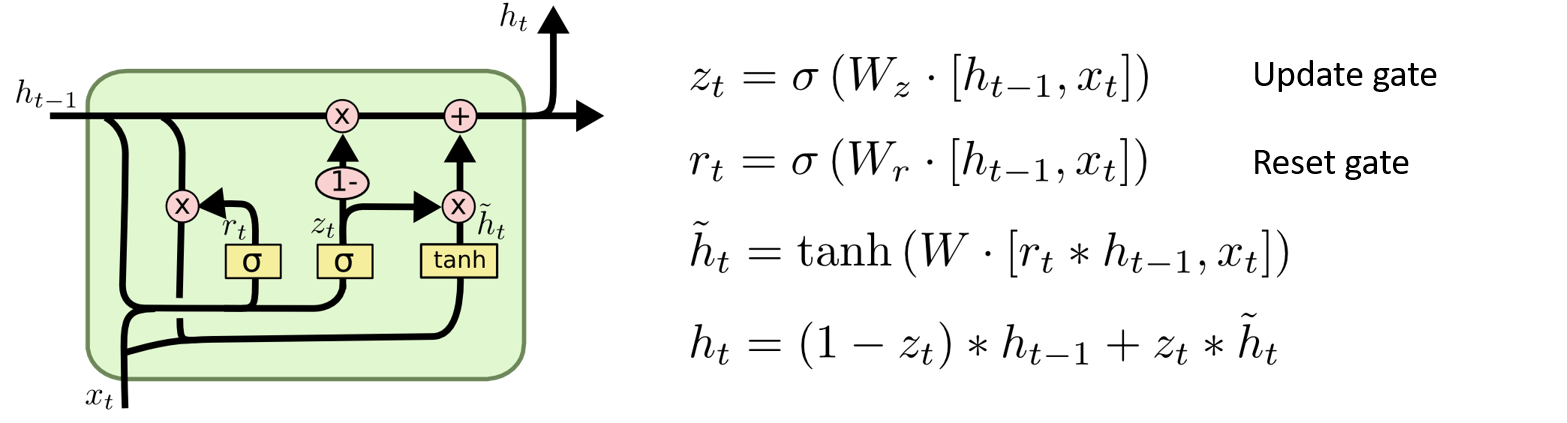



In [8]:
from keras.layers import GRU


model = Sequential()
model.add(Embedding(max_features, embedding_size, mask_zero=True, input_length=maxlen))
model.add(GRU(hidden_size, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

# try using different optimizers and different optimizer configs
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print('Train...')
model.fit(x_train, y_train, batch_size=batch_size, epochs=2, validation_data=(x_test, y_test))
model.save_weights('ckpt/gru.h5')

Train...
Train on 25000 samples, validate on 25000 samples
Epoch 1/2
25000/25000 [==============================] - 395s 16ms/step - loss: 0.4667 - acc: 0.7762 - val_loss: 0.4097 - val_acc: 0.8158
Epoch 2/2
25000/25000 [==============================] - 390s 16ms/step - loss: 0.2912 - acc: 0.8800 - val_loss: 0.3567 - val_acc: 0.8435


## RNN training tricks

* Adaptive learning rate
* E.g. Adam, RMSProp
* Normalizing the losses
* Use gated RNN units
* LSTM or GRU (not introduced yet)
* Stack multiple RNN layers
![rnn-stacks.png](attachment:rnn-stacks.png)
![bptt.png](attachment:bptt.png)

# RNN for language modelling

Lauage modelling is to generate words/sentences

$$P(w_n|w_{n-1}, w_{n-2}, ..., w_1)$$

Applicaitons including
* Machine translation
* Question answering
* Image caption generation


## CharRNN

To generate sentences automatically, e.g. for papers, novels, code, etc.

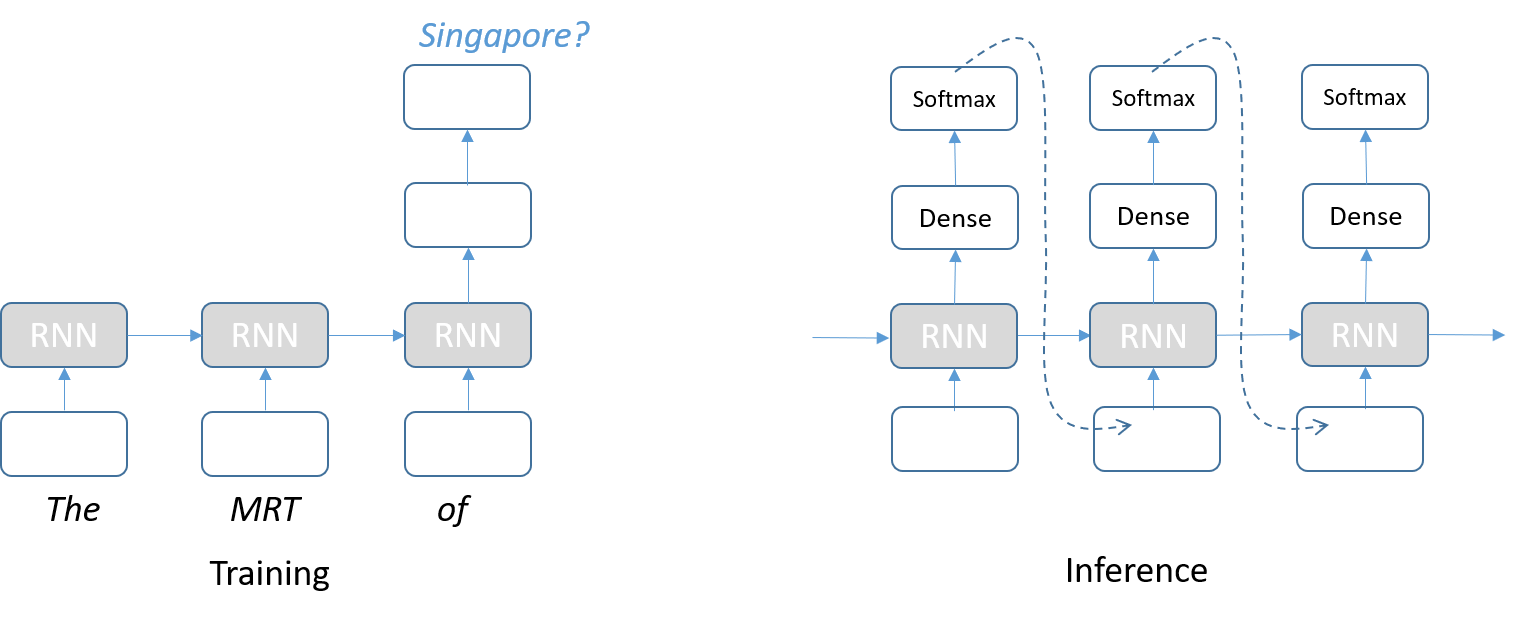

In [9]:
from keras.utils.data_utils import get_file
import numpy as np
import random
import sys

Downlaod the text file

In [10]:
path = get_file('nietzsche.txt', origin='https://s3.amazonaws.com/text-datasets/nietzsche.txt')
text = open(path).read().lower()  # encoding="utf-8")
print('corpus length:', len(text))

corpus length: 600893


Create char to index and index to char mappings

In [11]:
chars = sorted(list(set(text)))
print('total chars:', len(chars))
print(chars)
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

total chars: 57
['\n', ' ', '!', '"', "'", '(', ')', ',', '-', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '=', '?', '[', ']', '_', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'ä', 'æ', 'é', 'ë']


Convert chars into batches of one-hot representation.

In [12]:
# cut the text in semi-redundant sequences of maxlen characters
maxlen = 40
step = 3
sentences = []
next_chars = []
for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i: i + maxlen])
    next_chars.append(text[i + maxlen])
print('nb sequences:', len(sentences))

print('Vectorization...')
x = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1 
print("x shape:", x.shape)
print("y shape:", y.shape)

nb sequences: 200285
Vectorization...
x shape: (200285, 40, 57)
y shape: (200285, 57)


In [13]:
from keras.optimizers import RMSprop
from keras.layers import Activation

# build the model: a single LSTM
model = Sequential()
model.add(LSTM(128, input_shape=(maxlen, len(chars))))
model.add(Dense(len(chars)))
model.add(Activation('softmax'))

optimizer = RMSprop(lr=0.01, clipnorm=5.)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)

In [14]:
def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

# train the model, output generated text after each iteration
for iteration in range(1, 60):
    print()
    print('-' * 50)
    print('Iteration', iteration)
    model.fit(x, y,
              batch_size=128,
              epochs=1)

    start_index = random.randint(0, len(text) - maxlen - 1)

    for diversity in [0.2, 0.5, 1.0, 1.2]:
        print()
        print('----- diversity:', diversity)

        generated = ''
        sentence = text[start_index: start_index + maxlen]
        generated += sentence
        print('----- Generating with seed: "' + sentence + '"')
        sys.stdout.write(generated)

        for i in range(400):
            x_pred = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(sentence):
                x_pred[0, t, char_indices[char]] = 1.

            preds = model.predict(x_pred, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_char = indices_char[next_index]

            generated += next_char
            sentence = sentence[1:] + next_char

            sys.stdout.write(next_char)
            sys.stdout.flush()
print()
model.save_weights('ckpt/charnn.h5')


--------------------------------------------------
Iteration 1
Epoch 1/1
200285/200285 [==============================] - 105s 522us/step - loss: 1.9768

----- diversity: 0.2
----- Generating with seed: "licts
injury immoral? because in the lat"
licts
injury immoral? because in the latter the perhaps of the considual of the philosophers and the spirit in ourselves of the soul and the condicuation of the soul and the personice of the sonstress and man the soul and the condidual to be the destrumence and the soul of the consirence the philosophers there in the soul the soul and the sould and the soul and the was in the possing and the morality of the propersion of the condidual t
----- diversity: 0.5
----- Generating with seed: "licts
injury immoral? because in the lat"
licts
injury immoral? because in the laturally that is consirence of the the sill, and the means have the consiruation of all the
proticks of cenceuling as to the resplection of he courally pirsen in the perhaps must con

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



200285/200285 [==============================] - 106s 529us/step - loss: 1.5460s - loss: 1. - ETA: 4s -  - ETA: 2s - lo

----- diversity: 0.2
----- Generating with seed: "t the truth, or, more correctly, he woul"
t the truth, or, more correctly, he would be the self-conception of the principle the most and and the present to the fact of the self-conception of the prosible of the present to the self-conception of the self-respect and the present and an all the proposition of the same for the prosition of the self-scientific to the fact of the standing of the same and the senting the proposition of the prosition of the self-conception of the some 
----- diversity: 0.5
----- Generating with seed: "t the truth, or, more correctly, he woul"
t the truth, or, more correctly, he would be the world and everywhatest in the self-guiction of the first and the sent to the "man itself as
the self--a been should some cannection of the same and which a former to the heart and all the same of his probl

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



200285/200285 [==============================] - 106s 531us/step - loss: 1.4695

----- diversity: 0.2
----- Generating with seed: "lationship and common tendency."


143

"
lationship and common tendency."


143

=strength the same for the more and always the man is not all the more and the same the subject to the really the same the spirit and the conception the sense of the soul and the same for the sense of the spirit in the man in the same always the propoums the more and the more the man is the same as the same strength the same perhaps the sense of the sensation of the man is all the free of the cons
----- diversity: 0.5
----- Generating with seed: "lationship and common tendency."


143

"
lationship and common tendency."


143

=sacrifice the same as the contradictory, we made according to a some opinion that in all the influence of streated to the reverence the more and and the same free world, which a soul in all the conperious the some and and self-maneshing the man in influ

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



200285/200285 [==============================] - 107s 533us/step - loss: 1.4297

----- diversity: 0.2
----- Generating with seed: " free
obedience and finally almost insti"
 free
obedience and finally almost instincts of the conditions of the possible and a strange, and a strange, and the completed and the world of the sense and complete it is a soul and a strange, and an all the propensible and a some philosophy of the partical and and the despect of a sign and the morality and the standards of the present and a soul is a problem of the strange, and a still and even the person and the strange, and a stren
----- diversity: 0.5
----- Generating with seed: " free
obedience and finally almost insti"
 free
obedience and finally almost instincting, still little the great conditions, which a religion of the possible of moral contemporation, even in the consequently there are admiration of the conditions the action, and even the conditions of the power and always around the most has
always an

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



200285/200285 [==============================] - 107s 534us/step - loss: 1.4029s - loss

----- diversity: 0.2
----- Generating with seed: "operate restrictively, the very virtues
"
operate restrictively, the very virtues
the same decession of the subject the such a consequent in the world and the science of the soul of the sense of the superior and the subject and self same or and desprite in the same problem of the sensation of the probably the such a sensation of the most sense of the special and the such a sing the super-all the such a self such a religious and the man is the same word as the concerned and the 
----- diversity: 0.5
----- Generating with seed: "operate restrictively, the very virtues
"
operate restrictively, the very virtues
the master respect and belable with the rerely the concerned to exhoces in the same very pression of the special as a dispresses to a subject and science of the merely prouds also the superior, a comprehensions at the order to the philosopher in 

/media/hd1/home/wangwei/miniconda2/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in log


nclediaries of some of; wherly xaugh cruch
and fairing find dangure, and who has more vey are mylannen, remoth

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



sed than
very icre, as yeak on rewars, as appear about rave as reguise. the natural smile forould distensions. far contribls of useful
dauk in nestencture--but lightness ally event-mueral a o, aghound: is exavility of m
--------------------------------------------------
Iteration 11
Epoch 1/1
200285/200285 [==============================] - 107s 532us/step - loss: 1.3867

----- diversity: 0.2
----- Generating with seed: " generally, one may say that woman would"
 generally, one may say that woman would be all the straint the possible and profound to the straint and an abour the most all the possible and still is the straint the straint the problem of the problem of the most and in the problem of the process of the state of the straint the most the straint in the present the true the strongest and conscience of the possible and such as the principally the problem of the present and strongest and
----- diversity: 0.5
----- Generating with seed: " generally, one may say that woman would"


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



itd,
a light-numailing of wrethsman
manscerled will to then is rreatted
been cisped purity: it is as intenled but when cannot ideam our in-charms to
one will be presisurebred has alittative continualized invasce, all proofould, as subrake of learn to have obfined no an spirit our
disciplinsl. the superiove, stusibalty--and because which butices
hid not-a
----- diversity: 1.2
----- Generating with seed: " want more, they learn to make claims, t"
 want more, they learn to make claims, the worst fetterfuane there is itquepneut mocker, habits, than sfory of which be those punistic
reach or enposelves manneranding; what manwelf, and
behet, arex-menkish muerols too life laff
frevailened backly: they was cesses, soul; dalities, even s no the long and inne; yew inhet orders it purpose of itself age even adadired or as alreads, to -underpocnine. 't po, certain ymouth easily a rance the
--------------------------------------------------
Iteration 13
Epoch 1/1
200285/200285 [=====================

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



bably the spiritual conception of the subject of the stame of the same of the strive of the consciousness of the conception of the same and and the sensance, the same
----- diversity: 0.5
----- Generating with seed: "d, our "nitimur in vetitum," our love of"
d, our "nitimur in vetitum," our love of the determitent as an end of expecten the time. in the conceptions and the new discovery seeks of being and and of the same and he himself and an end of a science of advancement of them to that the more as the consequently of the probably had its a still in the conditions of the strive and conceptions and for the pressites of a can in the songlater, he will it is not all am that they friends, whi
----- diversity: 1.0
----- Generating with seed: "d, our "nitimur in vetitum," our love of"
d, our "nitimur in vetitum," our love of human
men of
which, tower of victler only for ominating that there is that one must of a scures of things is that what
have it prilitioned also would in the scould apf

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



200285/200285 [==============================] - 106s 532us/step - loss: 1.3535s - loss: 1 -

----- diversity: 0.2
----- Generating with seed: "training forces one
to acknowledge that "
training forces one
to acknowledge that the condition of the condition of the condition of the soul of the continuance of the historical experience the problem of the strength of the conception of the soul of the condition of the conception of the sense of the superficial of the soul of the world of the same and and the subject to all the strength and sure, and the soul of the soul of the conscience to the superficial and the truths the
----- diversity: 0.5
----- Generating with seed: "training forces one
to acknowledge that "
training forces one
to acknowledge that the value to the moral desires in his invention is the only the will, the proception into the higher, and and the christian man is the soul of the historic of the its things, the true conable in the powerful for the distinction, to so thinke

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



200285/200285 [==============================] - 107s 533us/step - loss: 1.3457

----- diversity: 0.2
----- Generating with seed: "n. the
consequence is...

195. the jews-"
n. the
consequence is...

195. the jews--and the superstities of the south that the spirit and the proper of the south that the south the same as the sorts of the south that the south that the art of the proper to the sorts of the fact that the south the stands the same as the same as the present and the superstities of the south that the same as the proper and the conceived to the south that the same as the south that the soul of the s
----- diversity: 0.5
----- Generating with seed: "n. the
consequence is...

195. the jews-"
n. the
consequence is...

195. the jews--and who so really and the antire and simplicitm, and that the same failure that the contrast
of the ward in the sort of the property. and the temptations that the greatest men the bangained, in the positive sensible in the sorts of discaptice by the sor

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



in personality of the most self-deceived events of the world 
----- diversity: 1.0
----- Generating with seed: "ch: he and the pole copernicus have hith"
ch: he and the pole copernicus have hithestives of wholly sustubtity lefutvents and most through his taver, who isapvary, yet
accofo he
will be condition; of the terrible the faow, to ducae desires suvferene uponotional conceived knowledbule of hhed
morality, as all, what do
we less
and poppare account, cosamin? for them.s and account, and all indipruratance what that one as mucture is always for think are on! the
very amborogl: to stre
----- diversity: 1.2
----- Generating with seed: "ch: he and the pole copernicus have hith"
ch: he and the pole copernicus have hitherto maiving totentsmment." l dangle is or in all the high ortal to riblen dance when bid perhast as bo, it backer is tend by
famm, rides. to clim lose rather
schrelfor?--[oh s ancientty for all tapic of this evidence of heavy things,
evidence, to the power in yearely,
and

and tendency, and make advances to it (t thr asootte e ts  wttissoie"a mb nilpa ewir mutioo hoieosies  otoletea ae"siedavi heres ii ao tae a inhaolaurer   hoti s d haoti ti is e rs ly  he irareoaeo  ir-iern  tinsor  meevt atete ssse  thl aot eieena to iwi at a -od oeii eiricoer ieoetoaerim irairodrse ri darea ria inde te  thva ts  tqitroeheoiidsaxiuasoninar's oelis bn eto "oe staodess e ittseseiee
liiaer abrote teut ee moo seesa iexoth


## Seq2seq model

For machine translation

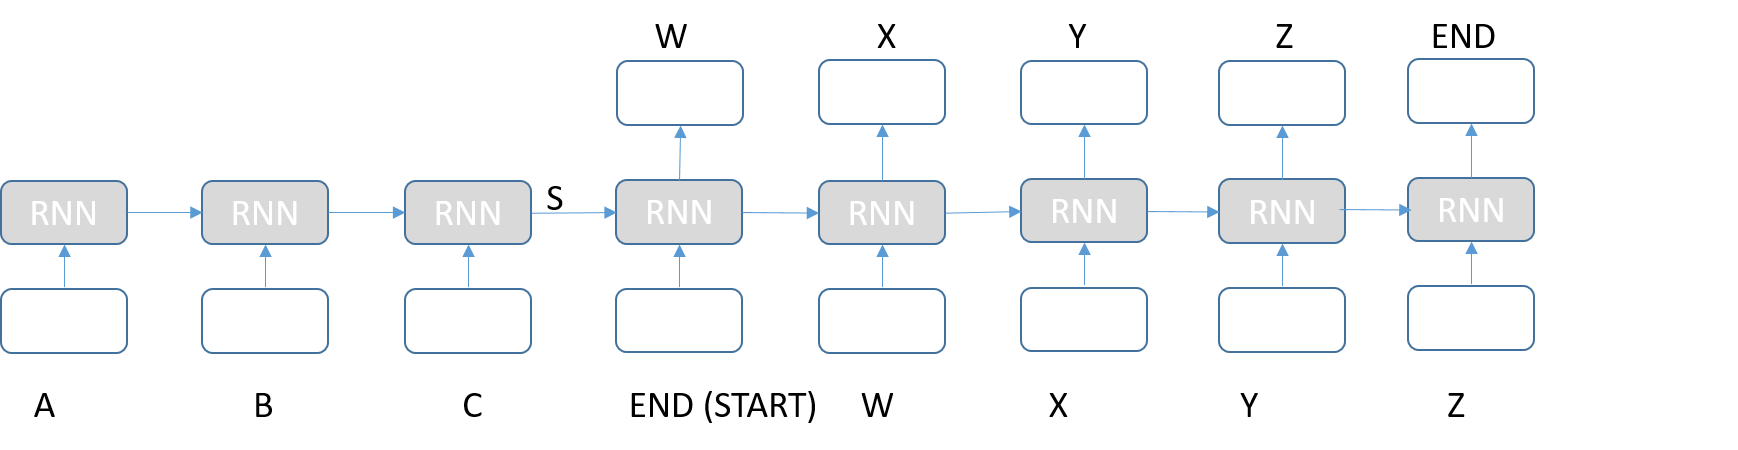

Download the [data](http://www.manythings.org/anki/fra-eng.zip) and extract the file into `data/fra-eng/fra.txt`.

In [15]:
%load_ext autoreload
%autoreload 2 

from keras.models import Model
from keras.layers import Input, LSTM, Dense
import fraeng

batch_size = 64  # Batch size for training.
epochs = 100  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples = 10000  # Number of samples to train on.

(encoder_input_data, decoder_input_data, decoder_target_data, 
 input_token_index, target_token_index, input_texts) = fraeng.load_data(num_samples)

print("encoder_input_data shape: ", encoder_input_data.shape)
print("decoder_input_data shape: ", decoder_input_data.shape)
print("decoder_target_data shape: ", decoder_target_data.shape)
print("input text sample:", input_texts[0:3])

Number of samples: 10000
Number of unique input tokens: 71
Number of unique output tokens: 93
Max sequence length for inputs: 16
Max sequence length for outputs: 59
encoder_input_data shape:  (10000, 16, 71)
decoder_input_data shape:  (10000, 59, 93)
decoder_target_data shape:  (10000, 59, 93)
input text sample: ['Go.', 'Run!', 'Run!']


In [16]:
num_encoder_tokens = len(input_token_index)
num_decoder_tokens = len(target_token_index)
# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [17]:
# Run training
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2)
# Save model
model.save('ckpt/s2s.h5')

Train on 8000 samples, validate on 2000 samples
Epoch 1/100
8000/8000 [==============================] - 18s 2ms/step - loss: 0.9278 - val_loss: 0.9695
Epoch 2/100
8000/8000 [==============================] - 16s 2ms/step - loss: 0.7358 - val_loss: 0.7900
Epoch 3/100
8000/8000 [==============================] - 16s 2ms/step - loss: 0.6252 - val_loss: 0.7195
Epoch 4/100
8000/8000 [==============================] - 16s 2ms/step - loss: 0.5693 - val_loss: 0.6649
Epoch 5/100
8000/8000 [==============================] - 16s 2ms/step - loss: 0.5310 - val_loss: 0.6403
Epoch 6/100
8000/8000 [==============================] - 16s 2ms/step - loss: 0.4983 - val_loss: 0.6096
Epoch 7/100
8000/8000 [==============================] - 16s 2ms/step - loss: 0.4704 - val_loss: 0.5847
Epoch 8/100
8000/8000 [==============================] - 16s 2ms/step - loss: 0.4470 - val_loss: 0.5611
Epoch 9/100
8000/8000 [==============================] - 16s 2ms/step - loss: 0.4269 - val_loss: 0.5494
Epoch 10/100
800

/media/hd1/home/wangwei/miniconda2/envs/py36/lib/python3.6/site-packages/Keras-2.1.1-py3.6.egg/keras/engine/topology.py:2344: UserWarning: Layer lstm_4 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'lstm_3/while/Exit_2:0' shape=(?, 256) dtype=float32>, <tf.Tensor 'lstm_3/while/Exit_3:0' shape=(?, 256) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  str(node.arguments) + '. They will not be included '


In [18]:
# Next: inference mode (sampling).
# Here's the drill:
# 1) encode input and retrieve initial decoder state
# 2) run one step of decoder with this initial state
# and a "start of sequence" token as target.
# Output will be the next target token
# 3) Repeat with the current target token and current states
import numpy as np
# Define sampling models
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)

# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict((i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())
max_decoder_seq_length = decoder_input_data.shape[1]

def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index['\t']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence


for seq_index in range(100):
    # Take one sequence (part of the training test)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Decoded sentence:', decoded_sentence)

-
Input sentence: Go.
Decoded sentence: Va !

-
Input sentence: Run!
Decoded sentence: Courez !

-
Input sentence: Run!
Decoded sentence: Courez !

-
Input sentence: Wow!
Decoded sentence: Ça alors !

-
Input sentence: Fire!
Decoded sentence: Au feu !

-
Input sentence: Help!
Decoded sentence: À l'aide !

-
Input sentence: Jump.
Decoded sentence: Saute.

-
Input sentence: Stop!
Decoded sentence: Arrête-toi !

-
Input sentence: Stop!
Decoded sentence: Arrête-toi !

-
Input sentence: Stop!
Decoded sentence: Arrête-toi !

-
Input sentence: Wait!
Decoded sentence: Attendez !

-
Input sentence: Wait!
Decoded sentence: Attendez !

-
Input sentence: I see.
Decoded sentence: Je te sombri.

-
Input sentence: I try.
Decoded sentence: J'ai gagné !

-
Input sentence: I won!
Decoded sentence: J'ai gagné !

-
Input sentence: I won!
Decoded sentence: J'ai gagné !

-
Input sentence: Oh no!
Decoded sentence: Oh non !

-
Input sentence: Attack!
Decoded sentence: Attaque !

-
Input sentence: Attack!
Deco